# Model Training Pipeline - Home Credit Default Risk

This notebook trains multiple models with hyperparameter tuning and MLflow tracking:
- Logistic Regression (baseline)
- Random Forest
- XGBoost (GPU-enabled on Mac if available)
- LightGBM (GPU-enabled on Mac if available)

All experiments are logged to MLflow server.

## 1. Setup and Imports

In [37]:
import sys
import os
import warnings
import platform
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

# Import custom modules - force reload
import importlib
if 'metrics' in sys.modules:
    importlib.reload(sys.modules['metrics'])
if 'model_utils' in sys.modules:
    importlib.reload(sys.modules['model_utils'])

from model_utils import *
from metrics import *

import joblib
from datetime import datetime

print("All imports successful!")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"MLflow version: {mlflow.__version__}")

All imports successful!
Python version: 3.11.14 (main, Dec  2 2025, 09:49:06) [Clang 17.0.0 (clang-1700.4.4.1)]
Pandas version: 2.3.3
XGBoost version: 3.1.2
LightGBM version: 4.6.0
MLflow version: 3.7.0


## 2. Detect GPU/Device Availability

In [38]:
# Detect platform and GPU availability
is_mac = platform.system() == 'Darwin'
is_apple_silicon = is_mac and platform.machine() == 'arm64'

print(f"Platform: {platform.system()}")
print(f"Machine: {platform.machine()}")
print(f"Apple Silicon: {is_apple_silicon}")

# Configure device settings
if is_apple_silicon:
    # Apple Silicon (M1/M2/M3) - try to use GPU
    xgb_device = 'cpu'  # XGBoost GPU support on Mac is experimental
    lgb_device = 'cpu'  # LightGBM GPU requires OpenCL setup
    print("\nNote: Using CPU for training (GPU support on Mac requires special builds)")
    print("All models will use n_jobs=-1 for maximum CPU utilization")
else:
    xgb_device = 'cpu'
    lgb_device = 'cpu'
    print("\nUsing CPU with multi-threading (n_jobs=-1)")

Platform: Darwin
Machine: arm64
Apple Silicon: True

Note: Using CPU for training (GPU support on Mac requires special builds)
All models will use n_jobs=-1 for maximum CPU utilization


## 3. Configure MLflow (Server Connection)

In [39]:
# Connect to MLflow server on localhost:5000
mlflow_server_uri = "http://localhost:5000"
mlflow.set_tracking_uri(mlflow_server_uri)

# Create or set experiment
experiment_name = "home_credit_default_risk"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment: {experiment_name}")
except:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment: {experiment_name}")

mlflow.set_experiment(experiment_name)

print(f"\nMLflow Configuration:")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  Experiment: {experiment_name}")
print(f"  Experiment ID: {experiment_id}")
print(f"\n✓ Connected to MLflow server!")
print(f"  View UI at: {mlflow_server_uri}")

Using existing experiment: home_credit_default_risk

MLflow Configuration:
  Tracking URI: http://localhost:5000
  Experiment: home_credit_default_risk
  Experiment ID: 370453507538469996

✓ Connected to MLflow server!
  View UI at: http://localhost:5000


## 4. Load Prepared Data

In [40]:
# Load the prepared data from notebook 01
print("Loading prepared data...")
df = pd.read_csv('../data/application_train_prepared.csv')

print(f"\nData shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]:,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading prepared data...

Data shape: (307511, 336)
Columns: 336
Rows: 307,511
Memory usage: 788.30 MB


## 5. Check Class Imbalance

Target column: TARGET

Class distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Class proportions:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Scale pos weight (for XGBoost): 11.39


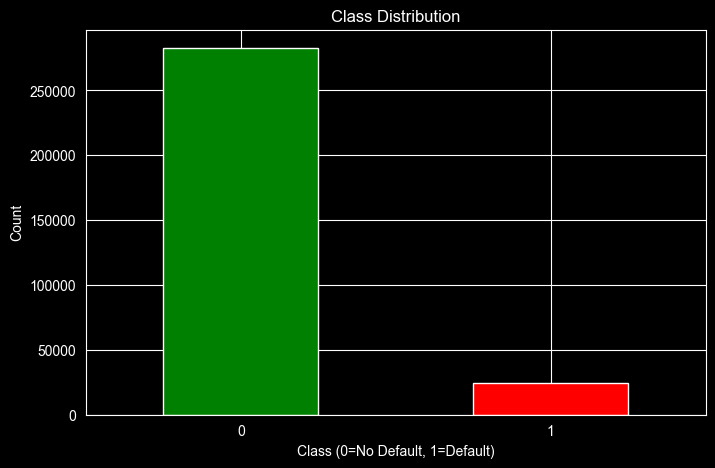

In [41]:
# Check target distribution
if 'TARGET' in df.columns:
    target_col = 'TARGET'
else:
    target_col = [col for col in df.columns if 'target' in col.lower()][0]

print(f"Target column: {target_col}")
print(f"\nClass distribution:")
print(df[target_col].value_counts())
print(f"\nClass proportions:")
print(df[target_col].value_counts(normalize=True))

# Calculate imbalance ratio for scale_pos_weight
n_neg = (df[target_col] == 0).sum()
n_pos = (df[target_col] == 1).sum()
scale_pos_weight = n_neg / n_pos
print(f"\nScale pos weight (for XGBoost): {scale_pos_weight:.2f}")

# Visualize
plt.figure(figsize=(8, 5))
df[target_col].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class (0=No Default, 1=Default)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 6. Prepare Data

In [42]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Stratified split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Feature scaling for Logistic Regression
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Save scaler
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.pkl')
print("\n✓ Scaler saved to ../models/scaler.pkl")

Features shape: (307511, 335)
Target shape: (307511,)

Training set: 246,008 samples
Test set: 61,503 samples

✓ Scaler saved to ../models/scaler.pkl


In [43]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model and return metrics
    """
    # Predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics with default threshold
    results = calculate_all_metrics(y_test, y_pred_proba, threshold=0.5)
    
    # Optimize threshold for business cost
    optimal_threshold = optimize_threshold(
        y_test, 
        y_pred_proba, 
        metric='business_cost',
        fn_cost=10,
        fp_cost=1
    )
    
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    business_cost = calculate_business_cost(y_test, y_pred_optimal, fn_cost=10, fp_cost=1)
    
    print(f"\n{'='*70}")
    print(f"{model_name} Results")
    print(f"{'='*70}")
    print(f"  AUC:                 {results['auc']:.4f}")
    print(f"  Accuracy:            {results['accuracy']:.4f}")
    print(f"  Precision:           {results['precision']:.4f}")
    print(f"  Recall:              {results['recall']:.4f}")
    print(f"  F1-Score:            {results['f1']:.4f}")
    print(f"  Optimal Threshold:   {optimal_threshold:.4f}")
    print(f"  Business Cost:       {business_cost:.2f}")
    print(f"{'='*70}")
    
    return {
        **results,
        'optimal_threshold': optimal_threshold,
        'business_cost_optimal': business_cost
    }

## 7. Helper Functions

## 8. Logistic Regression (Baseline)

In [44]:
print("\n" + "="*70)
print("Training Logistic Regression (Baseline)")
print("="*70)

lr_params = {
    'solver': 'lbfgs',
    'max_iter': 1000,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}

lr_model = LogisticRegression(**lr_params)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nRunning 5-fold cross-validation...")
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"CV AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train final model
print("\nTraining final model...")
lr_model.fit(X_train_scaled, y_train)

# Evaluate
lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

# Log to MLflow
with mlflow.start_run(run_name="logistic_regression_baseline"):
    mlflow.log_params(lr_params)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("device", "cpu")
    
    mlflow.log_metric("cv_auc_mean", cv_scores.mean())
    mlflow.log_metric("cv_auc_std", cv_scores.std())
    mlflow.log_metrics({
        "test_auc": lr_metrics['auc'],
        "test_accuracy": lr_metrics['accuracy'],
        "test_precision": lr_metrics['precision'],
        "test_recall": lr_metrics['recall'],
        "test_f1": lr_metrics['f1'],
        "optimal_threshold": lr_metrics['optimal_threshold'],
        "business_cost": lr_metrics['business_cost_optimal']
    })
    
    mlflow.sklearn.log_model(lr_model, "model")
    print("\n✓ Logged to MLflow!")

# Save model
joblib.dump(lr_model, '../models/logistic_regression.pkl')
print("✓ Model saved!")


Training Logistic Regression (Baseline)

Running 5-fold cross-validation...
CV AUC scores: [0.76199776 0.76379962 0.7707779  0.76589342 0.7662803 ]
Mean CV AUC: 0.7657 (+/- 0.0059)

Training final model...

Logistic Regression Results
  AUC:                 0.7684
  Accuracy:            0.7039
  Precision:           0.1710
  Recall:              0.6931
  F1-Score:            0.2743
  Optimal Threshold:   0.5152
  Business Cost:       31714.00


2025/12/13 23:11:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ Logged to MLflow!
🏃 View run logistic_regression_baseline at: http://localhost:5000/#/experiments/370453507538469996/runs/8ee24d33bac941d18e4891567088ec45
🧪 View experiment at: http://localhost:5000/#/experiments/370453507538469996
✓ Model saved!


## 9. Random Forest

In [45]:
print("\n" + "="*70)
print("Training Random Forest with RandomizedSearchCV")
print("="*70)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'],
    'random_state': [42],
    'n_jobs': [-1]
}

print("\nHyperparameter tuning (5 iterations, 2-fold CV)...")
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    rf_base, rf_param_grid,
    n_iter=5, cv=2, scoring='roc_auc',
    n_jobs=-1, random_state=42, verbose=1
)

rf_random.fit(X_train, y_train)
print(f"\nBest parameters: {rf_random.best_params_}")
print(f"Best CV AUC: {rf_random.best_score_:.4f}")

# Train final model with 5-fold CV
rf_model = RandomForestClassifier(**rf_random.best_params_)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"\n5-Fold CV AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

rf_model.fit(X_train, y_train)

# Evaluate
rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Log to MLflow
with mlflow.start_run(run_name="random_forest_tuned"):
    mlflow.log_params(rf_random.best_params_)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter_random_search", 20)
    mlflow.log_param("device", "cpu")
    
    mlflow.log_metric("cv_auc_mean", cv_scores_rf.mean())
    mlflow.log_metric("cv_auc_std", cv_scores_rf.std())
    mlflow.log_metrics({
        "test_auc": rf_metrics['auc'],
        "test_accuracy": rf_metrics['accuracy'],
        "test_precision": rf_metrics['precision'],
        "test_recall": rf_metrics['recall'],
        "test_f1": rf_metrics['f1'],
        "optimal_threshold": rf_metrics['optimal_threshold'],
        "business_cost": rf_metrics['business_cost_optimal']
    })
    
    mlflow.sklearn.log_model(rf_model, "model")
    print("\n✓ Logged to MLflow!")

joblib.dump(rf_model, '../models/random_forest.pkl')
print("✓ Model saved!")


Training Random Forest with RandomizedSearchCV

Hyperparameter tuning (5 iterations, 2-fold CV)...
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'class_weight': 'balanced'}
Best CV AUC: 0.7480

5-Fold CV AUC: 0.7511 (+/- 0.0044)

Random Forest Results
  AUC:                 0.7553
  Accuracy:            0.9178
  Precision:           0.4128
  Recall:              0.0443
  F1-Score:            0.0800
  Optimal Threshold:   0.1616
  Business Cost:       32783.00


2025/12/13 23:22:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ Logged to MLflow!
🏃 View run random_forest_tuned at: http://localhost:5000/#/experiments/370453507538469996/runs/8be26932a314421d864bc46134f516aa
🧪 View experiment at: http://localhost:5000/#/experiments/370453507538469996
✓ Model saved!


## 10. XGBoost (with device configuration)

In [46]:
print("\n" + "="*70)
print("Training XGBoost with RandomizedSearchCV")
print(f"Device: {xgb_device}")
print("="*70)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight],
    'tree_method': ['hist'],  # Fast histogram-based method
    'random_state': [42],
    'n_jobs': [-1]
}

print("\nHyperparameter tuning (5 iterations, 2-fold CV)...")
xgb_base = xgb.XGBClassifier()
xgb_random = RandomizedSearchCV(
    xgb_base, xgb_param_grid,
    n_iter=5, cv=2, scoring='roc_auc',
    n_jobs=-1, random_state=42, verbose=1
)

xgb_random.fit(X_train, y_train)
print(f"\nBest parameters: {xgb_random.best_params_}")
print(f"Best CV AUC: {xgb_random.best_score_:.4f}")

# Train final model
xgb_model = xgb.XGBClassifier(**xgb_random.best_params_)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"\n5-Fold CV AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

xgb_model.fit(X_train, y_train)

# Evaluate
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# Log to MLflow
with mlflow.start_run(run_name="xgboost_tuned"):
    mlflow.log_params(xgb_random.best_params_)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter_random_search", 20)
    mlflow.log_param("device", xgb_device)
    
    mlflow.log_metric("cv_auc_mean", cv_scores_xgb.mean())
    mlflow.log_metric("cv_auc_std", cv_scores_xgb.std())
    mlflow.log_metrics({
        "test_auc": xgb_metrics['auc'],
        "test_accuracy": xgb_metrics['accuracy'],
        "test_precision": xgb_metrics['precision'],
        "test_recall": xgb_metrics['recall'],
        "test_f1": xgb_metrics['f1'],
        "optimal_threshold": xgb_metrics['optimal_threshold'],
        "business_cost": xgb_metrics['business_cost_optimal']
    })
    
    mlflow.xgboost.log_model(xgb_model, "model")
    print("\n✓ Logged to MLflow!")

joblib.dump(xgb_model, '../models/xgboost.pkl')
print("✓ Model saved!")


Training XGBoost with RandomizedSearchCV
Device: cpu

Hyperparameter tuning (5 iterations, 2-fold CV)...
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best parameters: {'tree_method': 'hist', 'subsample': 0.6, 'scale_pos_weight': np.float64(11.387150050352467), 'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV AUC: 0.7646

5-Fold CV AUC: 0.7656 (+/- 0.0051)

XGBoost Results
  AUC:                 0.7695
  Accuracy:            0.7050
  Precision:           0.1724
  Recall:              0.6987
  F1-Score:            0.2766
  Optimal Threshold:   0.5253
  Business Cost:       31411.00


2025/12/13 23:23:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ Logged to MLflow!
🏃 View run xgboost_tuned at: http://localhost:5000/#/experiments/370453507538469996/runs/7321f130e94e4f83b0998f77255b6b43
🧪 View experiment at: http://localhost:5000/#/experiments/370453507538469996
✓ Model saved!


## 11. LightGBM (with device configuration)

In [47]:
print("\n" + "="*70)
print("Training LightGBM with RandomizedSearchCV")
print(f"Device: {lgb_device}")
print("="*70)

lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'class_weight': ['balanced'],
    'random_state': [42],
    'n_jobs': [-1],
    'verbose': [-1]
}

print("\nHyperparameter tuning (20 iterations, 3-fold CV)...")
lgb_base = lgb.LGBMClassifier()
lgb_random = RandomizedSearchCV(
    lgb_base, lgb_param_grid,
    n_iter=5, cv=2, scoring='roc_auc',
    n_jobs=-1, random_state=42, verbose=1
)

lgb_random.fit(X_train, y_train)
print(f"\nBest parameters: {lgb_random.best_params_}")
print(f"Best CV AUC: {lgb_random.best_score_:.4f}")

# Train final model
lgb_model = lgb.LGBMClassifier(**lgb_random.best_params_)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lgb = cross_val_score(lgb_model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"\n5-Fold CV AUC: {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std() * 2:.4f})")

lgb_model.fit(X_train, y_train)

# Evaluate
lgb_metrics = evaluate_model(lgb_model, X_test, y_test, "LightGBM")

# Log to MLflow
with mlflow.start_run(run_name="lightgbm_tuned"):
    mlflow.log_params(lgb_random.best_params_)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter_random_search", 20)
    mlflow.log_param("device", lgb_device)
    
    mlflow.log_metric("cv_auc_mean", cv_scores_lgb.mean())
    mlflow.log_metric("cv_auc_std", cv_scores_lgb.std())
    mlflow.log_metrics({
        "test_auc": lgb_metrics['auc'],
        "test_accuracy": lgb_metrics['accuracy'],
        "test_precision": lgb_metrics['precision'],
        "test_recall": lgb_metrics['recall'],
        "test_f1": lgb_metrics['f1'],
        "optimal_threshold": lgb_metrics['optimal_threshold'],
        "business_cost": lgb_metrics['business_cost_optimal']
    })
    
    mlflow.lightgbm.log_model(lgb_model, "model")
    print("\n✓ Logged to MLflow!")

joblib.dump(lgb_model, '../models/lightgbm.pkl')
print("✓ Model saved!")


Training LightGBM with RandomizedSearchCV
Device: cpu

Hyperparameter tuning (20 iterations, 3-fold CV)...
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best parameters: {'verbose': -1, 'subsample': 0.6, 'random_state': 42, 'num_leaves': 31, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'class_weight': 'balanced'}
Best CV AUC: 0.7710

5-Fold CV AUC: 0.7747 (+/- 0.0042)

LightGBM Results
  AUC:                 0.7793
  Accuracy:            0.7246
  Precision:           0.1826
  Recall:              0.6935
  F1-Score:            0.2891
  Optimal Threshold:   0.5152
  Business Cost:       30600.00


2025/12/13 23:24:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ Logged to MLflow!
🏃 View run lightgbm_tuned at: http://localhost:5000/#/experiments/370453507538469996/runs/6bb9c83da68a4367b061bf5a07b7c998
🧪 View experiment at: http://localhost:5000/#/experiments/370453507538469996
✓ Model saved!


## 12. Model Comparison


MODEL COMPARISON
              Model      AUC  Accuracy  Precision   Recall  F1-Score  Business Cost  Optimal Threshold
Logistic Regression 0.768390  0.703917   0.170964 0.693051  0.274271          31714           0.515152
      Random Forest 0.755310  0.917760   0.412758 0.044310  0.080029          32783           0.161616
            XGBoost 0.769466  0.704974   0.172433 0.698691  0.276602          31411           0.525253
           LightGBM 0.779312  0.724648   0.182594 0.693454  0.289073          30600           0.515152

🏆 CHAMPION MODEL: LightGBM
   Business Cost: 30600.00
   AUC: 0.7793
   Optimal Threshold: 0.5152

✓ Results saved to ../reports/model_comparison.csv


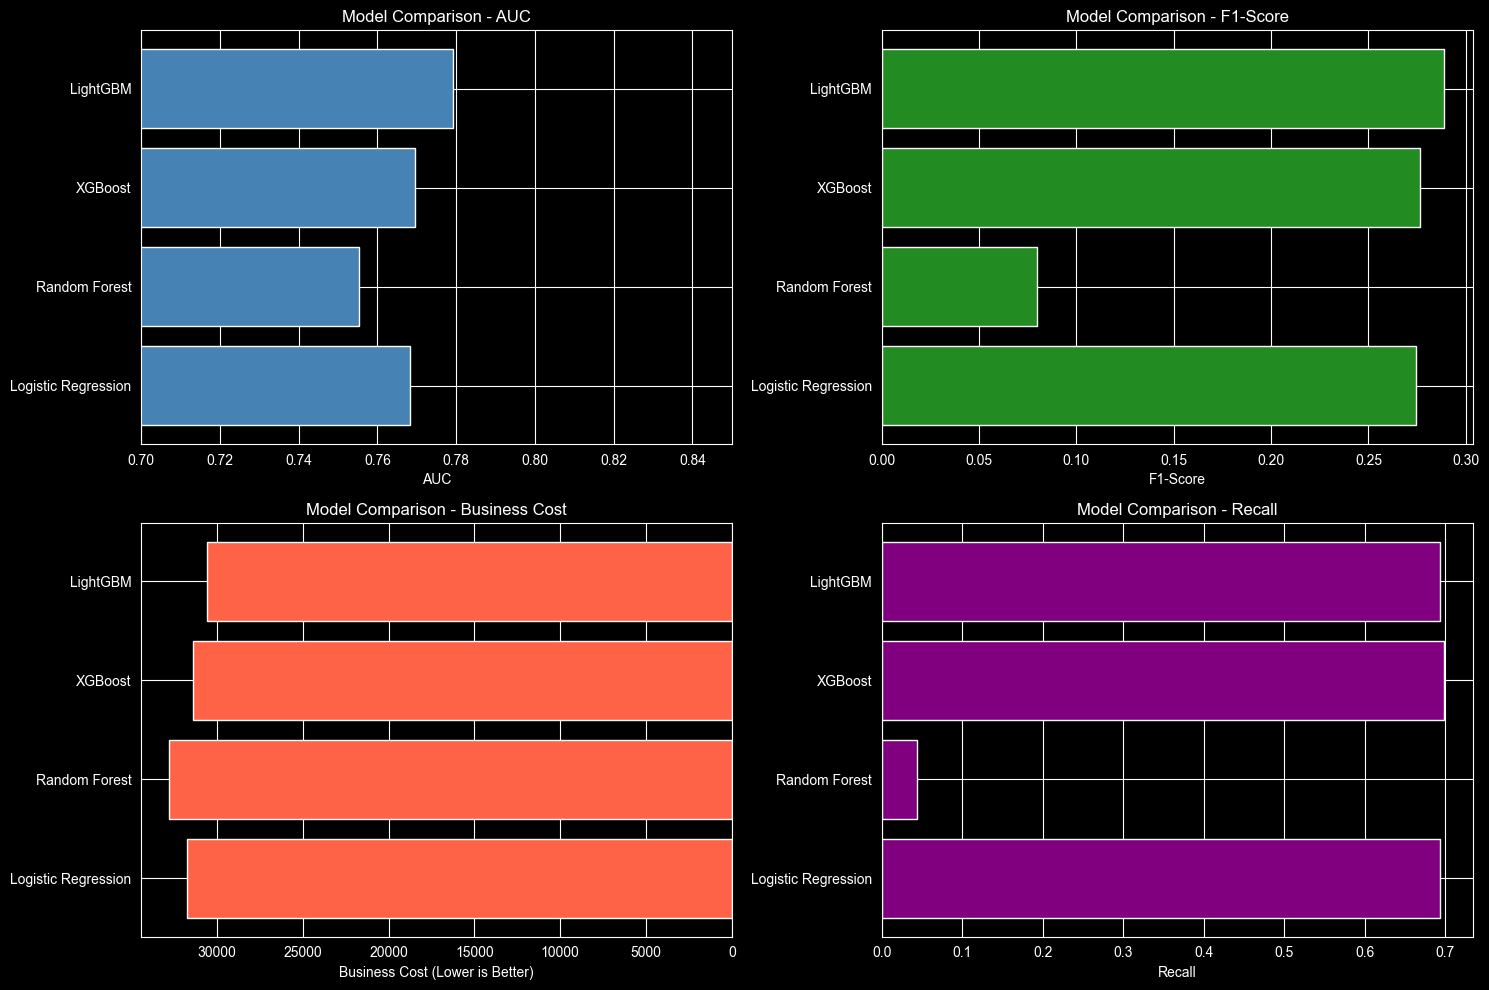

✓ Comparison plot saved to ../reports/figures/model_comparison.png


In [48]:
# Compile all results
comparison_df = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'AUC': lr_metrics['auc'],
        'Accuracy': lr_metrics['accuracy'],
        'Precision': lr_metrics['precision'],
        'Recall': lr_metrics['recall'],
        'F1-Score': lr_metrics['f1'],
        'Business Cost': lr_metrics['business_cost_optimal'],
        'Optimal Threshold': lr_metrics['optimal_threshold']
    },
    {
        'Model': 'Random Forest',
        'AUC': rf_metrics['auc'],
        'Accuracy': rf_metrics['accuracy'],
        'Precision': rf_metrics['precision'],
        'Recall': rf_metrics['recall'],
        'F1-Score': rf_metrics['f1'],
        'Business Cost': rf_metrics['business_cost_optimal'],
        'Optimal Threshold': rf_metrics['optimal_threshold']
    },
    {
        'Model': 'XGBoost',
        'AUC': xgb_metrics['auc'],
        'Accuracy': xgb_metrics['accuracy'],
        'Precision': xgb_metrics['precision'],
        'Recall': xgb_metrics['recall'],
        'F1-Score': xgb_metrics['f1'],
        'Business Cost': xgb_metrics['business_cost_optimal'],
        'Optimal Threshold': xgb_metrics['optimal_threshold']
    },
    {
        'Model': 'LightGBM',
        'AUC': lgb_metrics['auc'],
        'Accuracy': lgb_metrics['accuracy'],
        'Precision': lgb_metrics['precision'],
        'Recall': lgb_metrics['recall'],
        'F1-Score': lgb_metrics['f1'],
        'Business Cost': lgb_metrics['business_cost_optimal'],
        'Optimal Threshold': lgb_metrics['optimal_threshold']
    }
])

print("\n" + "="*90)
print("MODEL COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Select champion model
best_model_idx = comparison_df['Business Cost'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\n🏆 CHAMPION MODEL: {best_model_name}")
print(f"   Business Cost: {comparison_df.loc[best_model_idx, 'Business Cost']:.2f}")
print(f"   AUC: {comparison_df.loc[best_model_idx, 'AUC']:.4f}")
print(f"   Optimal Threshold: {comparison_df.loc[best_model_idx, 'Optimal Threshold']:.4f}")

# Save results
os.makedirs('../reports', exist_ok=True)
comparison_df.to_csv('../reports/model_comparison.csv', index=False)
print("\n✓ Results saved to ../reports/model_comparison.csv")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# AUC
axes[0, 0].barh(comparison_df['Model'], comparison_df['AUC'], color='steelblue')
axes[0, 0].set_xlabel('AUC')
axes[0, 0].set_title('Model Comparison - AUC')
axes[0, 0].set_xlim([0.7, 0.85])

# F1-Score
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], color='forestgreen')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model Comparison - F1-Score')

# Business Cost (lower is better)
axes[1, 0].barh(comparison_df['Model'], comparison_df['Business Cost'], color='tomato')
axes[1, 0].set_xlabel('Business Cost (Lower is Better)')
axes[1, 0].set_title('Model Comparison - Business Cost')
axes[1, 0].invert_xaxis()

# Recall
axes[1, 1].barh(comparison_df['Model'], comparison_df['Recall'], color='purple')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Model Comparison - Recall')

plt.tight_layout()
os.makedirs('../reports/figures', exist_ok=True)
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved to ../reports/figures/model_comparison.png")

## 13. Training Summary

In [49]:
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Training samples:      {X_train.shape[0]:,}")
print(f"Test samples:          {X_test.shape[0]:,}")
print(f"Features:              {X_train.shape[1]:,}")
print(f"Class imbalance:       {scale_pos_weight:.2f}:1")
print(f"\nModels trained:        4")
print(f"MLflow runs:           4")
print(f"MLflow server:         {mlflow_server_uri}")
print(f"\nBest model:            {best_model_name}")
print(f"Best business cost:    {comparison_df.loc[best_model_idx, 'Business Cost']:.2f}")
print(f"Device used:           {'Apple Silicon (optimized CPU)' if is_apple_silicon else 'CPU'}")
print("="*70)

print("\n✅ Training Complete!")
print(f"\n📊 View results: {mlflow_server_uri}")
print("📁 Models saved in: ../models/")
print("📈 Reports saved in: ../reports/")
print("\n➡️  Next: Run 03_explainability.ipynb for SHAP analysis")


TRAINING SUMMARY
Training samples:      246,008
Test samples:          61,503
Features:              335
Class imbalance:       11.39:1

Models trained:        4
MLflow runs:           4
MLflow server:         http://localhost:5000

Best model:            LightGBM
Best business cost:    30600.00
Device used:           Apple Silicon (optimized CPU)

✅ Training Complete!

📊 View results: http://localhost:5000
📁 Models saved in: ../models/
📈 Reports saved in: ../reports/

➡️  Next: Run 03_explainability.ipynb for SHAP analysis
